Isolation Forest for Anomaly Detection

In [44]:
import zipfile
import os

zip_path = "C:/Users/ey896/Downloads/웹로그데이터셋.zip"        # 데이터 가져오기
extract_dir = "/Users/ey896/Downloads/Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)

['labeled.csv']

In [45]:
import pandas as pd

csv_path = "/Users/ey896/Downloads/Dataset/labeled.csv" 

df = pd.read_csv(csv_path)

df      #데이터셋 확인


,ip,time,method,url,protocol,status,size,referrer,user_agent,extra,no,label,type
0,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,2,0,benign
1,31.56.96.51,2019-01-22 00:26:16+00:00,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-,3,0,benign
2,91.99.72.15,2019-01-22 00:26:17+00:00,GET,/product/31893/62100/سشوار-خانگی-پرنسلی-مدل-PR...,HTTP/1.1,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-,5,0,benign
3,178.253.33.51,2019-01-22 00:26:19+00:00,GET,/m/product/32574/62991/ماشین-اصلاح-صورت-پرنسلی...,HTTP/1.1,200,20406,"https://www.zanbil.ir/m/filter/p5767,t156?name...",Mozilla/5.0 (Linux; Android 5.1; HTC Desire 72...,-,13,0,benign
4,91.99.72.15,2019-01-22 00:26:19+00:00,GET,/product/10075/13903/مایکروفر-رومیزی-سامسونگ-م...,HTTP/1.1,200,41725,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,-,15,0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9282179,188.229.21.56,2019-01-26 16:59:13+00:00,GET,/content/view/shoppingRules,HTTP/1.1,302,0,https://www.zanbil.ir/m/product/32106/62372/ما...,Mozilla/5.0 (Linux; Android 7.0; SM-N920C Buil...,-,10365148,0,benign
9282180,5.127.220.71,2019-01-26 16:59:13+00:00,GET,/apple-touch-icon-120x120.png,HTTP/1.1,404,32420,-,MobileSafari/604.1 CFNetwork/976 Darwin/18.2.0,-,10365149,0,benign
9282181,5.213.7.50,2019-01-26 16:59:13+00:00,GET,/m/product/18962/غذا-ساز-مولینکس-مدل-FP7367RT,HTTP/1.1,200,20959,https://www.google.com/,Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 like...,-,10365150,0,benign
9282182,109.125.169.52,2019-01-26 16:59:13+00:00,GET,/image/{{basketItem.id}}?type=productModel&wh=...,HTTP/1.1,200,5,https://www.zanbil.ir/,Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20...,-,10365151,0,benign


EDA

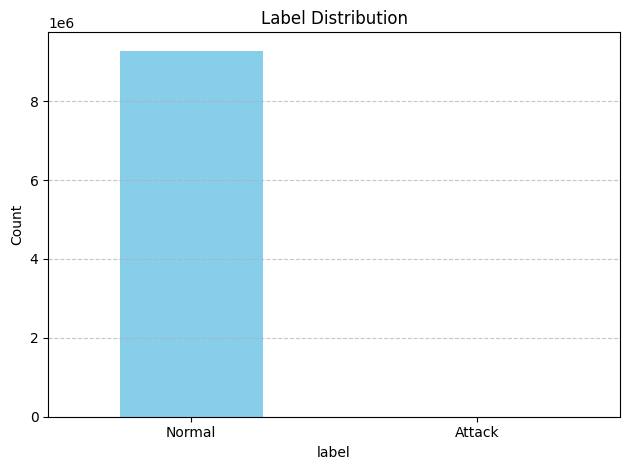

In [28]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])        # 로그 라벨 확인 및 시각화(모두 정상)
plt.title('Label Distribution')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Attack'], rotation=0)
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


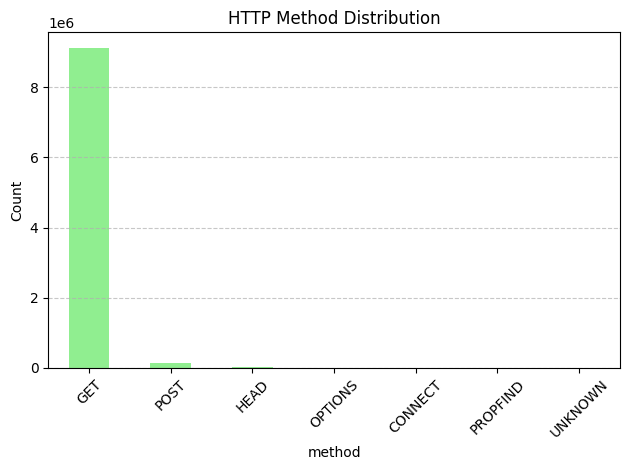

In [29]:
valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH', 'PROPFIND'} # method 전처리
df['method'] = df['method'].apply(lambda x: x if x in valid_methods else 'UNKNOWN')


df['method'].value_counts().plot(kind='bar', color='lightgreen')        # method 시각화
plt.title('HTTP Method Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


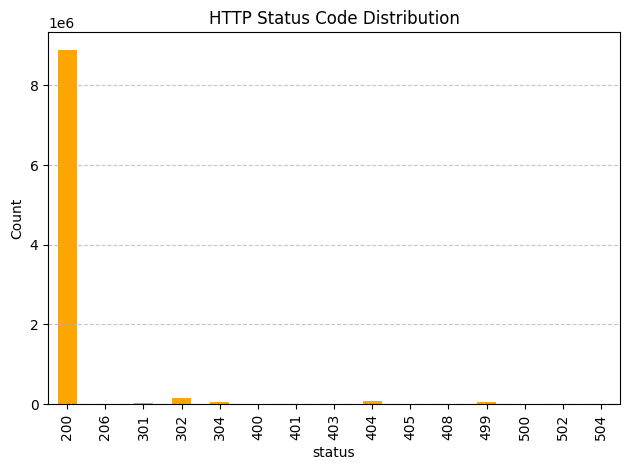

In [30]:
df['status'].value_counts().sort_index().plot(kind='bar', color='orange')        # 상태코드 시각화
plt.title('HTTP Status Code Distribution')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


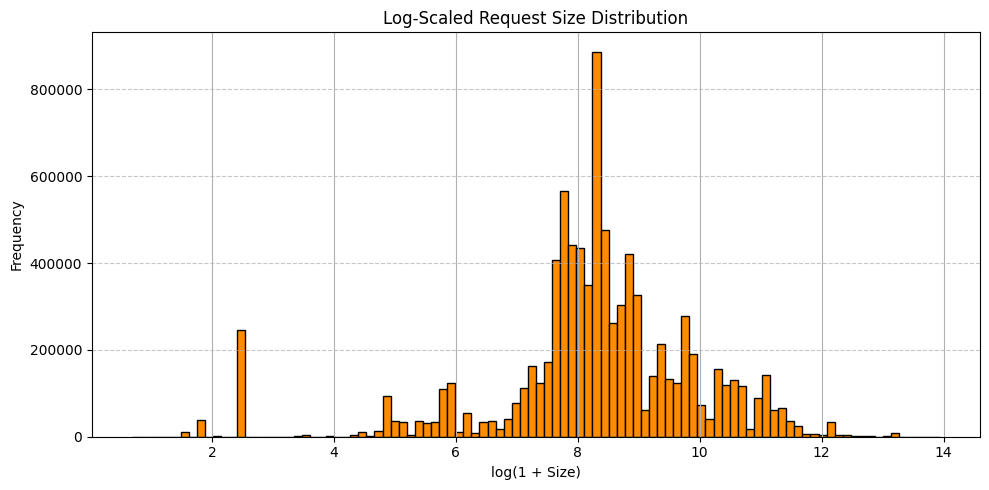

In [31]:
import numpy as np
import matplotlib.pyplot as plt

log_size = np.log1p(df[df['size'] > 0]['size'])         # 요청한 size 시각화

plt.figure(figsize=(10, 5))
log_size.hist(bins=100, color='darkorange', edgecolor='black')
plt.title('Log-Scaled Request Size Distribution')
plt.xlabel('log(1 + Size)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


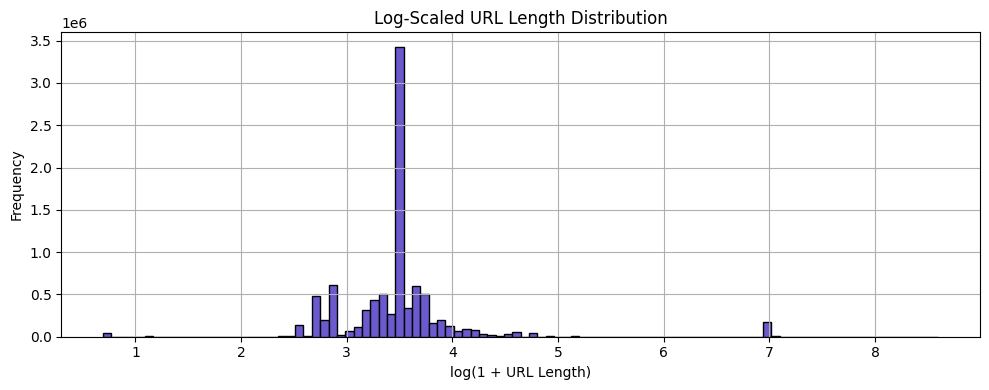

In [32]:
import numpy as np

df['url_length'] = df['url'].apply(lambda x: len(str(x)))       # URL 길이 시각화
log_url_length = np.log1p(df['url_length'])

plt.figure(figsize=(10, 4))
log_url_length.hist(bins=100, color='slateblue', edgecolor='black')
plt.title('Log-Scaled URL Length Distribution')
plt.xlabel('log(1 + URL Length)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



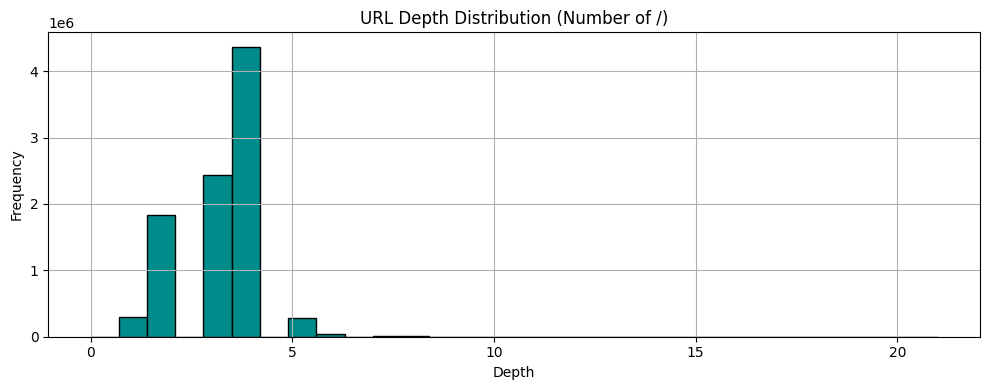

In [33]:
df['url_depth'] = df['url'].apply(lambda x: str(x).count('/'))

plt.figure(figsize=(10, 4))      # URL Depth 시각화(/의 개수)
df['url_depth'].hist(bins=30, color='darkcyan', edgecolor='black')
plt.title('URL Depth Distribution (Number of /)')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [37]:
print("unique user_agent :", df['user_agent'].nunique()) # user-agent 확인
df['user_agent'].value_counts().head(10)


unique user_agent : 28331


user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                           746572
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                            702672
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                        636897
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                               552142
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                            454961
Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                340970
Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Ver

In [39]:
print(df.columns)


Index(['ip', 'time', 'url', 'protocol', 'status', 'size', 'referrer',
       'user_agent', 'extra', 'no', 'label', 'type', 'url_length', 'url_depth',
       'has_query_param', 'url_special_char_count', 'agent_length',
       'ref_exists', 'method_GET', 'method_TRACE', 'method_OPTIONS',
       'method_CONNECT', 'method_PATCH', 'method_POST', 'method_HEAD',
       'method_DELETE', 'method_PUT', 'method_UNKNOWN'],
      dtype='object')


In [ ]:
import pandas as pd
import re
import joblib 

valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH'} # 전처리
df['method'] = df['method'].apply(lambda x: x if x in valid_methods else 'UNKNOWN') # 위의 칼럼에서 존재하지 않는애라면 UNKNOWN으로


df['url_length'] = df['url'].apply(len)         # URL 길이
df['url_depth'] = df['url'].apply(lambda x: x.count('/'))       # URL 깊이 (/의 개수)
df['has_query_param'] = df['url'].apply(lambda x: 1 if '?' in x else 0)         # URL 쿼리 파라미터 개수(?의 개수) 
df['url_special_char_count'] = df['url'].apply(lambda x: len(re.findall(r"[^\w/]", str(x))))    # URL 내 특수문자 수
df['agent_length'] = df['user_agent'].apply(lambda x: len(x) if isinstance(x, str) else 0)      # User-Agent 길이
df['ref_exists'] = df['referrer'].apply(lambda x: 1 if isinstance(x, str) and len(x.strip()) > 1 else 0)    # Referrer 존재 여부

df['method'] = pd.Categorical(df['method'], categories=list(valid_methods) + ['UNKNOWN'])
df = pd.get_dummies(df, columns=['method']) #method는 One-hot encoding적용

method_cols = [col for col in df.columns if col.startswith('method_')] # 적용후 새로운 칼럼


IOC_PATTERNS = joblib.load(r"c:\Users\ey896\OneDrive\Desktop\AI_log\app\model\ioc_keywords.pkl")

def count_ioc(text, keyword_list):      #IOC 등장 횟수세는 함수 정의
    text = str(text).lower()
    return sum(1 for pattern in keyword_list if pattern in text)


df['uri_ioc_count'] = df['url'].apply(lambda x: count_ioc(x, IOC_PATTERNS['url']))         # URL에서 IoC 개수
df['ua_ioc_count'] = df['user_agent'].apply(lambda x: count_ioc(x, IOC_PATTERNS['user_agent']) if isinstance(x, str) else 0) #User-Agent에서 IoC 개수
df['ioc_total_count'] = df.apply(
    lambda row: count_ioc(row.get('url', ''), IOC_PATTERNS['url'])     #Referrer + URI + User-Agent를 모두 합쳐서 ioc_total_count로
                + count_ioc(row.get('user_agent', ''), IOC_PATTERNS['user_agent']),
    axis=1
)

features = [                
    'status', 'size', 'url_length', 'url_depth', 'has_query_param',         #최종 학습 피처
    'agent_length', 'ref_exists',
    'url_special_char_count', 'uri_ioc_count', 'ua_ioc_count', 'ioc_total_count'
] + method_cols


X = df[features]



KeyError: 'user-agent'

In [ ]:
from sklearn.ensemble import IsolationForest

                                                        
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)      # isolation_forest 모델 학습
model.fit(X)

scores = model.decision_function(X)

preds = model.predict(X)

df['anomaly_score'] = scores
df['is_anomaly'] = preds

임의의 로그 만들어서 테스트 해보기

In [ ]:
def preprocess_test_log(log, method_cols_ref, ioc_patterns):                # 전처리 함수 만들기
    import re
    features = {}

    url = str(log.get('url', ''))
    user_agent = str(log.get('user_agent', ''))
    referrer = str(log.get('referrer', ''))
    method = str(log.get('method', '')).upper()

    valid_methods = {'GET', 'POST', 'PUT', 'DELETE', 'OPTIONS', 'HEAD', 'CONNECT', 'TRACE', 'PATCH'}
    method_final = method if method in valid_methods else 'UNKNOWN'

    features['status'] = int(log.get('status', 200))
    features['size'] = int(log.get('size', 0))
    features['url_length'] = len(url)
    features['url_depth'] = url.count('/')
    features['has_query_param'] = 1 if '?' in url else 0
    features['url_special_char_count'] = len(re.findall(r"[^\w/]", url))
    features['agent_length'] = len(user_agent)
    features['ref_exists'] = 1 if isinstance(referrer, str) and len(referrer.strip()) > 1 else 0

    def count_ioc(text):
        text = str(text).lower()
        return sum(1 for pattern in ioc_patterns if pattern in text)

    features['uri_ioc_count'] = count_ioc(url)
    features['ua_ioc_count'] = count_ioc(user_agent)
    features['ioc_total_count'] = (
        features['uri_ioc_count'] +
        features['ua_ioc_count']
    
    )

    for col in method_cols_ref:
        features[col] = 0
    method_col = f'method_{method_final}'
    if method_col in method_cols_ref:
        features[method_col] = 1

    return features


In [ ]:
#테스트용 로그
test_log = {
    'url': '/home',
    'user_agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'referrer': 'https://www.naver.com/',
    'method': 'GET',
    'status': 200,
    'size': 6124
}




In [ ]:
raw_feat = preprocess_test_log(test_log, method_cols, IOC_PATTERNS)             # 동일한 전처리

# 누락 피처 보완
for col in features:
    if col not in raw_feat:
        raw_feat[col] = 0

X_test = pd.DataFrame([raw_feat])[features]                             # 컬럼 순서 일치

def scale_score(raw_score, score_min=-0.1804, score_max=0.2810):        # min-max 스케줄링 적용
    raw_score = np.clip(raw_score, score_min, score_max)
    norm_score = (raw_score - score_min) / (score_max - score_min)      # 0~1 정규화
    inverted_score = 1 - norm_score                                     # 높을수록 비정상 로그
    return round(inverted_score * 100, 2)                               # 100점 만점



In [ ]:
X_test = pd.DataFrame([raw_feat])[features]

# 예측
raw_score = model.decision_function(X_test)[0]
user_score = scale_score(raw_score)

# 출력
print(f"모델 raw 점수: {raw_score:.4f}")
print(f"사용자 점수: {user_score}/100")

모델 raw 점수: 0.1866
사용자 점수: 20.46/100


In [ ]:
import joblib

# 모델 저장
##joblib.dump(model, 'isolation_model.pkl')
##joblib.dump(features, 'features.pkl')
##joblib.dump(method_cols, 'method_cols.pkl')



['method_cols.pkl']

In [ ]:
import joblib

model = joblib.load('isolation_model.pkl')
features = joblib.load('features.pkl')
method_cols = joblib.load('method_cols.pkl')

print(f"features 개수: {len(features)}")
print(f"method_cols 예시: {method_cols[:3]}")


features 개수: 21
method_cols 예시: ['method_CONNECT', 'method_GET', 'method_POST']


In [22]:
import os
import joblib

# 현재 notebook 위치에서 2단계 상위로: 프로젝트 루트
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # notebook → app → 프로젝트 루트
MODEL_DIR = os.path.join(ROOT_DIR, "app", "model")
os.makedirs(MODEL_DIR, exist_ok=True)

IOC_PATTERNS = {
    "url": sorted(set(s.lower() for s in [
        'NULL', 'CHR', 'ALL', 'UNION', 'CHAR', 'FROM', 'THEN', 'WHEN', 'END', 'CASE', 'ELSE', 'DUAL',
        'DBMS_PIPE', 'RECEIVE_MESSAGE', 'INFORMATION_SCHEMA', 'CHARACTER_SETS', 'ELT',
        'CONCAT', 'RAND', 'XMLType', 'COUNT', 'GROUP', 'UPPER', 'CONVERT', 'INT',
        'NUMERIC', 'CAST', 'shell_exec', 'hink', 'tmp', 'Solstice', 'wget', 'chmod', 'bins', 'mips', 'dlink', 'cli',
        'thinkphp', 'Karu', 'efjins', 'rift', 'cmd', 'workspace', 'git', 'xmlrpc', 'htaccess', 'aws', 'userpro', 'zoomsounds',
        'shell', 'htpasswd', 'dzs', 'rsd', 'svn', 'ini', 'entries', 'xshell', 'admins', 'wshell',
        'wlwmanifest', 'wordpress', 'credentials', 'env', 'cpanelphpmyadmin',
        'direct_download', '_phpMyAdmin', 'ajax_load', 'ajax', 'Unus', 'cpadmin', 'cpadmindb',
        'bash_history', 'filepath', 'file_link', 'mbox', 'languages','mTheme',
        'manipulator', 'pl', 'revslider_show_image', 'wptf'
    ])),
    "user_agent": sorted(set(s.lower() for s in [
    'sqlmap', 'curl', 'wget', 'python', 'nmap', 'nikto', 
    'httpclient', 'libwww-perl', 'masscan', 'fuzzer', 'robots'
]))

}



save_path = os.path.join(MODEL_DIR, "ioc_keywords.pkl")
joblib.dump(IOC_PATTERNS, save_path)
print(f"저장 완료: {save_path}")


저장 완료: c:\Users\ey896\OneDrive\Desktop\AI_log\app\model\ioc_keywords.pkl


In [23]:
import joblib
import os

# 저장한 파일 경로
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # notebook → app → 프로젝트 루트
MODEL_DIR = os.path.join(ROOT_DIR, "app", "model")
load_path = os.path.join(MODEL_DIR, "ioc_keywords.pkl")

# 불러오기
ioc_patterns = joblib.load(load_path)

# 확인
print("[IOC - URL 패턴]")
print(ioc_patterns["url"])

print("\n[IOC - User-Agent 패턴]")
print(ioc_patterns["user_agent"])


[IOC - URL 패턴]
['_phpmyadmin', 'admins', 'ajax', 'ajax_load', 'all', 'aws', 'bash_history', 'bins', 'case', 'cast', 'char', 'character_sets', 'chmod', 'chr', 'cli', 'cmd', 'concat', 'convert', 'count', 'cpadmin', 'cpadmindb', 'cpanelphpmyadmin', 'credentials', 'dbms_pipe', 'direct_download', 'dlink', 'dual', 'dzs', 'efjins', 'else', 'elt', 'end', 'entries', 'env', 'file_link', 'filepath', 'from', 'git', 'group', 'hink', 'htaccess', 'htpasswd', 'information_schema', 'ini', 'int', 'karu', 'languages', 'manipulator', 'mbox', 'mips', 'mtheme', 'null', 'numeric', 'pl', 'rand', 'receive_message', 'revslider_show_image', 'rift', 'rsd', 'shell', 'shell_exec', 'solstice', 'svn', 'then', 'thinkphp', 'tmp', 'union', 'unus', 'upper', 'userpro', 'wget', 'when', 'wlwmanifest', 'wordpress', 'workspace', 'wptf', 'wshell', 'xmlrpc', 'xmltype', 'xshell', 'zoomsounds']

[IOC - User-Agent 패턴]
['curl', 'fuzzer', 'httpclient', 'libwww-perl', 'masscan', 'nikto', 'nmap', 'python', 'robots', 'sqlmap', 'wget']
